In [ ]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Any, List, Optional
from pathlib import Path
import numpy as np
import pandas as pd
from flovopy.asl.wrappers2 import run_single_event, find_event_files, run_all_events

from obspy import read_inventory

# Base project directories
PROJECTDIR = "/Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver"
LOCALPROJECTDIR = "/Users/GlennThompson/work/PROJECTS/SSADenver_local"
OUTPUT_DIR = f"{LOCALPROJECTDIR}/asl_results"
INVENTORY_XML = f"/Users/glennthompson/Dropbox/MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT = Path("/Users/glennthompson/Dropbox/MONTSERRAT_DEM_WGS84_MASTER.tif")

# I/O
INPUT_DIR = f"{PROJECTDIR}/ASL_inputs/biggest_pdc_events"
DIST_MODE = "3d"        # include elevation\
GLOBAL_CACHE = f"{PROJECTDIR}/asl_global_cache"
#OUTPUT_DIR = GLOBAL_CACHE

# Montserrat default region (lon_min, lon_max, lat_min, lat_max)
from flovopy.core.mvo import REGION_DEFAULT, dome_location
print(REGION_DEFAULT)
print(dome_location)

# Load inventory once
INV = read_inventory(INVENTORY_XML)
print(f"[INV] Networks: {len(INV)}  Stations: {sum(len(n) for n in INV)}  Channels: {sum(len(sta) for net in INV for sta in net)}")


GRIDFILE_DEFAULT = "/Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl"

station_corrections_df = pd.read_csv(f"{PROJECTDIR}/station_gains_intervals.csv")
annual_station_corrections_df = pd.read_csv(f"{PROJECTDIR}/station_gains_intervals_by_year.csv")


# Set up parameters that will be inherited to plot background topo maps, on top of which other maps will be created

In [ ]:
from flovopy.asl.grid import Grid
gridobj = Grid.load(GRIDFILE_DEFAULT)
print(gridobj)

topo_kw = {
    "inv": INV,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "frame": True,
    "dome_location": dome_location,
}
#gridobj.plot(show=True, force_all_nodes=True, scale=5.0, topo_map_kwargs=topo_kw);

# Set up ASL and physics parameters

In [ ]:

REFINE_SECTOR = False   # enable triangular dome-to-sea refinement


# Build an ASL Conigration object, which will be inherited by downstream functions
This describes the physical parameters, the station metadata, the grid, the misfit algorithm, etc.

In [ ]:
from flovopy.processing.sam import VSAM 
from flovopy.asl.config import ASLConfig
print(OUTPUT_DIR)
cfg = ASLConfig(
    inventory=INV,
    output_base=str(OUTPUT_DIR),
    gridobj=gridobj,
    global_cache=GLOBAL_CACHE,
    station_correction_dataframe=station_corrections_df,
    wave_kind = "surface", # "surface" or "body"
    speed = 1.5, # km/s
    Q = 100, # attenuation quality factor
    peakf = 8.0, # Hz
    dist_mode = "3d", # or "2d"
    misfit_engine = "l2", # check
    window_seconds = 5.0, # length of time window for amplitude measurement
    min_stations = 5, # minimum number of stations required to locate event
    sam_class = VSAM, # or DSAM
    sam_metric = "LP", # or one of "mean", "median", "max", "rms", "VLP", or "LP"
    debug=True,
)
cfg.build()
print(cfg.outdir)

# add station corrections too!

#  stash the whole asl_config?

In [ ]:
import pandas as pd
from pathlib import Path

MAX_EVENTS = 999999

input_dir = Path(INPUT_DIR)
event_files = list(find_event_files(input_dir))
print(f"Found {len(event_files)} event files.")

rows = [{"num": num, "f": str(f)} for num, f in enumerate(event_files[:MAX_EVENTS])]

df = pd.DataFrame(rows)
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
csvfile = Path(OUTPUT_DIR) / "mseed_files.csv"
df.to_csv(csvfile, index=False)

print(f"CSV written: {csvfile}")

file_indexes = [116]
selected_files = [event_files[i] for i in file_indexes]
print(selected_files)

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from obspy import read, read_inventory
from importlib import reload
import flovopy.processing.envelopes as env
reload(env)
from flovopy.processing.envelopes import (
    align_waveforms,
    align_waveforms_global,
    envelopes_stream,
    envelope_delays,
    locate_with_grid_from_delays,
)
from flovopy.asl.grid import Grid
from flovopy.asl.wrappers2 import find_event_files
from flovopy.core.mvo import dome_location

# -------------------------- Config --------------------------
PROJECTDIR      = "/Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver"
LOCALPROJECTDIR = "/Users/GlennThompson/work/PROJECTS/SSADenver_local"
OUTPUT_DIR      = f"{LOCALPROJECTDIR}/asl_results"
INPUT_DIR       = f"{PROJECTDIR}/ASL_inputs/biggest_pdc_events"
GLOBAL_CACHE    = f"{PROJECTDIR}/asl_global_cache"

INVENTORY_XML   = "/Users/glennthompson/Dropbox/MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT     = Path("/Users/glennthompson/Dropbox/MONTSERRAT_DEM_WGS84_MASTER.tif")
GRIDFILE_DEFAULT= "/Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl"

SMOOTH_SECONDS  = 1.0
MAX_LAG_SECONDS = 8.0
MIN_XCORR       = 0.5
best_file_nums  = [35, 36, 40, 52, 82, 83, 84, 116, 310, 338]

INV     = read_inventory(INVENTORY_XML)
gridobj = Grid.load(GRIDFILE_DEFAULT)
input_dir = Path(INPUT_DIR)
event_files = list(find_event_files(input_dir))
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("Dome (assumed source) =", dome_location)

# -------------------------- Helpers --------------------------
def _gc_km(lon1, lat1, lon2, lat2):
    """Haversine great-circle distance (km)."""
    r = 6371.0
    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = (np.sin(dlat/2)**2
         + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(dlon/2)**2)
    return float(2*r*np.arcsin(np.sqrt(a)))

def _top_n_lags(lags_dict, n=5):
    """Return top-N station lags by absolute value as list of (sta, lag)."""
    items = [(k, v) for k, v in lags_dict.items()]
    items.sort(key=lambda kv: abs(kv[1]), reverse=True)
    return items[:n]

# -------------------------- Run suite --------------------------
rows = []
per_event_lags = []  # store detailed lags to print later

for file_num in best_file_nums:
    try:
        event_path = str(event_files[file_num])
    except Exception as e:
        print(f"[WARN] file_num={file_num} not found in event_files list: {e}")
        continue

    eventdir       = Path(OUTPUT_DIR) / str(file_num)
    score_vs_c_png = str(eventdir / "score_vs_c.png")
    ccf_plot_dir   = str(eventdir / "ccf_plots")
    topo_png       = str(eventdir / "best_location_topo.png")
    eventdir.mkdir(parents=True, exist_ok=True)

    print(f"\n=== Event {file_num} ===")
    try:
        st = read(event_path).select(component="Z")
    except Exception as e:
        print(f"[ERROR] read failed for {event_path}: {e}")
        continue
    st.merge(fill_value="interpolate")
    st.detrend("linear")

    # ---------- 1) Reference-based alignment ----------
    aligned_st_ref, lags_ref = align_waveforms(
        st.copy(),
        max_lag_s=MAX_LAG_SECONDS,
        smooth_s=SMOOTH_SECONDS,
        decimate_to=None
    )

    # Optional “check” pass (kept, but not strictly needed)
    _, lags_ref_check = align_waveforms(
        aligned_st_ref.copy(),
        max_lag_s=MAX_LAG_SECONDS,
        smooth_s=SMOOTH_SECONDS,
        decimate_to=None
    )

    # ---------- 2) Global alignment ----------
    aligned_st_global, lags_global, delays = align_waveforms_global(
        st.copy(),
        max_lag_s=MAX_LAG_SECONDS,
        min_corr=MIN_XCORR,
        smooth_s=SMOOTH_SECONDS,
        decimate_to=None
    )

    # ---------- 2b) CCFs (for plots / extra debug) ----------
    env_st = envelopes_stream(st, smooth_s=SMOOTH_SECONDS, decimate_to=None)
    delays_dbg, ccfs = envelope_delays(
        env_st,
        max_lag_s=MAX_LAG_SECONDS,
        min_corr=MIN_XCORR,
        return_ccfs=True
    )
    # We’ll use the global alignment delays for the locator
    delays_for_loc = delays

    # ---------- 3) Locator ----------
    result = locate_with_grid_from_delays(
        gridobj,
        GLOBAL_CACHE,
        inventory=INV,
        delays=delays_for_loc,
        stream=st,
        # Keep a physically plausible range; dense for nice Stage-A curve
        c_range=(0.1, 5.0),
        n_c=80,
        debug=True,
        ccfs=ccfs,
        plot_ccf_dir=ccf_plot_dir,
        plot_score_vs_c=score_vs_c_png,
        dome_location=dome_location,   # dict {'lat','lon','elev'}
        verbose=False,
        # Debias knobs:
        min_delta_d_km=0.5,
        min_abs_lag_s=0.15,
        delta_d_weight=True,
        c_phys=(0.5, 3.5),
        auto_ref=True,
        # Topo overlay
        topo_map_out=topo_png,
        topo_dem_path=str(DEM_DEFAULT),
    )

    # Extract best node info
    best_node   = result.get("node")
    best_c      = result.get("speed", np.nan)
    best_score  = result.get("score", np.nan)
    n_pairs     = result.get("n_pairs", np.nan)
    best_lon    = result.get("lon", np.nan)
    best_lat    = result.get("lat", np.nan)
    best_elev   = result.get("elev_m", np.nan)

    # Extract Stage-A (dome) c_best if available
    dbg = result.get("debug_info", {}) or {}
    scores_c = dbg.get("scores_c", [])
    c_dome   = np.nan
    score_dome = np.nan
    if scores_c:
        # take min finite score
        vals = np.array([s["score"] for s in scores_c], float)
        vals[~np.isfinite(vals)] = np.inf
        if np.isfinite(vals).any():
            k = int(np.argmin(vals))
            c_dome    = float(scores_c[k]["c"])
            score_dome= float(scores_c[k]["score"])

    # Distance from dome to best node
    dome_lon = float(dome_location["lon"])
    dome_lat = float(dome_location["lat"])
    dist_km  = _gc_km(dome_lon, dome_lat, best_lon, best_lat) if np.isfinite(best_lon) else np.nan

    # Save per-event row
    rows.append({
        "event_idx": file_num,
        "file_path": event_path,
        # alignment summaries
        "n_ref_lags": len(lags_ref),
        "n_global_lags": len(lags_global),
        # locator
        "c_at_dome_kms": c_dome,
        "score_at_dome": score_dome,
        "c_at_bestnode_kms": best_c,
        "score_bestnode": best_score,
        "n_pairs_used": n_pairs,
        "bestnode_lon": best_lon,
        "bestnode_lat": best_lat,
        "bestnode_elev_m": best_elev,
        "dome_to_best_km": dist_km,
        # keep JSON-ifiable snapshots of lags
        "lags_ref": lags_ref,
        "lags_ref_check": lags_ref_check,
        "lags_global": lags_global,
    })

    # Keep a lighter human-readable lag printout
    per_event_lags.append({
        "event_idx": file_num,
        "top_ref_lags": _top_n_lags(lags_ref, n=6),
        "top_global_lags": _top_n_lags(lags_global, n=6),
    })

# -------------------------- Summaries --------------------------
df = pd.DataFrame(rows)
csv_out = str(Path(OUTPUT_DIR) / "suite_summary.csv")
df.to_csv(csv_out, index=False)
print(f"\nWrote summary CSV -> {csv_out}")

# Pretty print a compact table of key metrics
show_cols = [
    "event_idx",
    "c_at_dome_kms", "score_at_dome",
    "c_at_bestnode_kms", "score_bestnode",
    "n_pairs_used", "dome_to_best_km",
]
print("\nPer-event summary (key metrics):")
print(df[show_cols].to_string(index=False, justify="center", float_format=lambda v: f"{v:,.3f}"))

def _describe(series, name):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return f"{name}: no finite values"
    return (f"{name}: n={len(s)}, mean={s.mean():.3f}, median={s.median():.3f}, "
            f"std={s.std(ddof=1):.3f}, min={s.min():.3f}, max={s.max():.3f}")

print("\n=== Descriptive stats ===")
print(_describe(df["c_at_dome_kms"], "c @ dome (km/s)"))
print(_describe(df["c_at_bestnode_kms"], "c @ best node (km/s)"))
print(_describe(df["dome_to_best_km"], "distance: dome→best (km)"))
print(_describe(df["score_bestnode"], "best-node score"))
print(_describe(df["n_pairs_used"], "n_pairs used"))

# Print best time-lags (top |lag|) for each event for both methods
print("\n=== Top lags by |lag| per event ===")
for rec in per_event_lags:
    e = rec["event_idx"]
    ref_top = ", ".join([f"{sta}:{lag:+.2f}s" for sta, lag in rec["top_ref_lags"]])
    glb_top = ", ".join([f"{sta}:{lag:+.2f}s" for sta, lag in rec["top_global_lags"]])
    print(f"[{e}] ref: {ref_top}")
    print(f"[{e}] glb: {glb_top}")


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# Paths
outdir = Path("/Users/GlennThompson/work/PROJECTS/SSADenver_local/asl_results")
df = pd.read_csv(outdir / "suite_summary.csv")

# --- Parse lag strings into dicts ---
def parse_lag_strings(series):
    parsed = []
    for txt in series.fillna(""):
        ev = {}
        for part in str(txt).split(","):
            if ":" not in part:
                continue
            sta, lag = part.strip().split(":")
            try:
                ev[sta.strip()] = float(lag.replace("s", ""))
            except ValueError:
                continue
        parsed.append(ev)
    return parsed

lags_ref = parse_lag_strings(df.get("lags_ref", pd.Series()))
lags_glb = parse_lag_strings(df.get("lags_global", pd.Series()))

# --- Build pairwise differences per event ---
def compute_pairwise_diffs(lag_dicts):
    diffs = []
    for lagmap in lag_dicts:
        pairs = {}
        stations = sorted(lagmap.keys())
        for i in range(len(stations)):
            for j in range(i+1, len(stations)):
                si, sj = stations[i], stations[j]
                d = lagmap[si] - lagmap[sj]
                pairs[(si, sj)] = d
        diffs.append(pairs)
    return diffs

pairdiffs_ref = compute_pairwise_diffs(lags_ref)
pairdiffs_glb = compute_pairwise_diffs(lags_glb)

# --- Summarize across events with MAD outlier filter ---
def summarize_pairwise(pairdiffs, label):
    records = []
    all_pairs = sorted({p for ev in pairdiffs for p in ev.keys()})
    for (a, b) in all_pairs:
        vals = [ev[(a, b)] for ev in pairdiffs if (a, b) in ev]
        if not vals:
            continue
        arr = np.array(vals, dtype=float)
        med = np.median(arr)
        mad = np.median(np.abs(arr - med))
        # Outlier guard
        keep = arr[np.abs(arr - med) <= 3 * mad] if mad > 0 else arr
        if len(keep) < 2:
            continue
        rec = dict(
            pair=f"{a}-{b}",
            sta_a=a,
            sta_b=b,
            n=len(keep),
            median_s=float(np.median(keep)),
            mean_s=float(np.mean(keep)),
            std=float(np.std(keep)),
            mad=float(mad),
            min=float(np.min(keep)),
            max=float(np.max(keep)),
            method=label,
        )
        records.append(rec)
    return pd.DataFrame.from_records(records)

stable_ref = summarize_pairwise(pairdiffs_ref, "ref")
stable_glb = summarize_pairwise(pairdiffs_glb, "global")

# --- Save to CSV in the expected format ---
f_ref = outdir / "pairwise_lagdiff_stats_ref_stable.csv"
f_glb = outdir / "pairwise_lagdiff_stats_global_stable.csv"
stable_ref.to_csv(f_ref, index=False)
stable_glb.to_csv(f_glb, index=False)

print("Wrote:", f_ref)
print("Wrote:", f_glb)

# Save out
outdir = Path("/Users/GlennThompson/work/PROJECTS/SSADenver_local/asl_results")
stable_ref.to_csv(outdir / "pairwise_lagdiff_stats_ref_stable.csv", index=False)
stable_glb.to_csv(outdir / "pairwise_lagdiff_stats_global_stable.csv", index=False)

print("Wrote:", outdir / "pairwise_lagdiff_stats_ref_stable.csv")
print("Wrote:", outdir / "pairwise_lagdiff_stats_global_stable.csv")

In [ ]:
import re
import numpy as np
import pandas as pd

# --- paths/objects you already have in your notebook ---
# gridobj, INV, GLOBAL_CACHE (or CACHE_DIR), OUTPUT_DIR, dome_location

# ---------- 1) Load & clean the stable pairs CSV ----------
stable_csv = f"{OUTPUT_DIR}/pairwise_lagdiff_stats_global_stable.csv"
stab = pd.read_csv(stable_csv)

def clean_sta(s: str) -> str:
    # upper-case and strip everything that isn't a letter/number (kills quotes/braces)
    return re.sub(r'[^A-Za-z0-9]', '', str(s)).upper()

# If sta_a/sta_b are missing, derive from 'pair' column like "MBGB-MBRY"
if not {'sta_a','sta_b'}.issubset(stab.columns):
    if 'pair' not in stab.columns:
        raise ValueError(f"'pair' column not found in {stable_csv} and no sta_a/sta_b present.")
    ab = stab['pair'].astype(str).str.split('-', n=1, expand=True)
    ab.columns = ['sta_a','sta_b']
    stab = pd.concat([stab, ab], axis=1)

# Clean station codes
stab['sta_a'] = stab['sta_a'].apply(clean_sta)
stab['sta_b'] = stab['sta_b'].apply(clean_sta)

# Ensure *_s columns exist (the estimator expects seconds; your CSV’s mean/median already are seconds)
if 'mean_s' not in stab.columns and 'mean' in stab.columns:
    stab['mean_s'] = stab['mean']
if 'median_s' not in stab.columns and 'median' in stab.columns:
    stab['median_s'] = stab['median']

# Optional robust scale column
if 'mad_scaled' not in stab.columns and 'mad' in stab.columns:
    stab['mad_scaled'] = 1.4826 * stab['mad']

print("[clean] sample of cleaned rows:")
print(stab[['pair','sta_a','sta_b','mean_s','median_s','std','mad','mad_scaled']].head(8).to_string(index=False))

# ---------- 2) Estimate speed (source at dome) using cleaned table ----------
from flovopy.asl.distances import compute_or_load_distances

def estimate_speed_from_stable_pairs(
    grid, inventory, cache_dir, dome_location, stable_df,
    use_value="mean_s", weight_with="mad_scaled",
    min_delta_d_km=0.02, min_abs_tau_s=0.00,
    c_bounds=(0.2, 6.0), uncert_floor_s=0.05,
):
    # collapse distances to STA keys
    node_dists, coords, meta = compute_or_load_distances(
        grid, cache_dir=cache_dir, inventory=inventory, stream=None, use_elevation=True
    )
    def to_sta_key(seed_or_sta: str) -> str:
        # MV.MBGB..HHZ -> MBGB ; MBGB -> MBGB
        parts = str(seed_or_sta).split(".")
        return parts[1] if len(parts) >= 2 else str(seed_or_sta)

    dist_by_sta = {}
    for full_id, vec in node_dists.items():
        key = to_sta_key(full_id)
        # keep first occurrence for that station
        dist_by_sta.setdefault(key, vec)

    # resolve dome node
    def resolve_dome_node(grid, dome):
        if isinstance(dome, int):
            return dome
        glon = np.asarray(grid.gridlon).ravel()
        glat = np.asarray(grid.gridlat).ravel()
        if isinstance(dome, dict) and {'lon','lat'} <= set(dome):
            lon, lat = float(dome['lon']), float(dome['lat'])
        elif isinstance(dome, (tuple, list)) and len(dome) == 2:
            lon, lat = float(dome[0]), float(dome[1])
        else:
            return None
        return int(np.argmin((glon - lon)**2 + (glat - lat)**2))

    dome_idx = resolve_dome_node(grid, dome_location)
    if dome_idx is None:
        raise ValueError("Could not resolve dome node from dome_location")

    # guards and per-pair speeds
    rows, rejects = [], []
    for _, r in stable_df.iterrows():
        a, b = str(r['sta_a']), str(r['sta_b'])
        if a not in dist_by_sta or b not in dist_by_sta:
            rejects.append((a,b,"missing_station_in_inventory"))
            continue
        da, db = float(dist_by_sta[a][dome_idx]), float(dist_by_sta[b][dome_idx])
        if not (np.isfinite(da) and np.isfinite(db)):
            rejects.append((a,b,"nan_distance"))
            continue
        delta_d = abs(da - db)                  # km
        tau = float(r[use_value])               # s
        if not (delta_d >= min_delta_d_km and abs(tau) >= min_abs_tau_s):
            reason = "small_delta_d" if delta_d < min_delta_d_km else "small_tau"
            rejects.append((a,b,reason))
            continue
        c_ab = delta_d / abs(tau) if abs(tau) > 0 else np.inf
        # weight from uncertainty column if present
        if weight_with in r and np.isfinite(r[weight_with]) and (r[weight_with] > 0):
            sig = max(float(r[weight_with]), uncert_floor_s)
            w = 1.0 / (sig**2)
        else:
            w = 1.0
        rows.append({"sta_a":a, "sta_b":b, "delta_d_km":delta_d,
                     "delta_tau_s":abs(tau), "c_pair_km_s":c_ab, "weight":w})

    per_pair = pd.DataFrame(rows)
    print(f"[speed] kept {len(per_pair)} pairs, rejected {len(rejects)}")
    if rejects:
        rej = pd.DataFrame(rejects, columns=["sta_a","sta_b","reason"])
        print("[speed] reject tally:\n", rej['reason'].value_counts(dropna=False))

    if per_pair.empty:
        raise ValueError("No usable stable pairs after cleaning/guards. Check station naming and CSV contents.")

    # clamp c to plausible bounds
    m = np.isfinite(per_pair['c_pair_km_s']) & (per_pair['c_pair_km_s'] >= c_bounds[0]) & (per_pair['c_pair_km_s'] <= c_bounds[1])
    per_pair = per_pair.loc[m].copy()
    if per_pair.empty:
        raise ValueError("All c estimates were outside c_bounds. Try widening c_bounds or relax guards.")

    # robust weighted median + bootstrap CI
    def weighted_median(x, w):
        x, w = np.asarray(x, float), np.asarray(w, float)
        order = np.argsort(x); x, w = x[order], w[order]
        csum = np.cumsum(w) / np.sum(w)
        k = np.searchsorted(csum, 0.5)
        return float(x[min(k, len(x)-1)])

    c_vals = per_pair['c_pair_km_s'].values
    w_vals = per_pair['weight'].values
    c_hat  = weighted_median(c_vals, w_vals)

    rng = np.random.default_rng(42)
    B = 500 if len(c_vals) >= 5 else 200
    p = w_vals / np.sum(w_vals)
    boots = [weighted_median(c_vals[rng.choice(len(c_vals), size=len(c_vals), replace=True, p=p)], w_vals) for _ in range(B)]
    ci_lo, ci_hi = float(np.percentile(boots, 16)), float(np.percentile(boots, 84))

    return {
        "per_pair": per_pair.sort_values("c_pair_km_s"),
        "speed_km_s": c_hat,
        "ci_68": (ci_lo, ci_hi),
        "n_pairs_used": int(per_pair.shape[0]),
    }

# ---- run the estimator on the cleaned table ----
CACHE_DIR = GLOBAL_CACHE  # or your variable name
res = estimate_speed_from_stable_pairs(
    grid=gridobj,
    inventory=INV,
    cache_dir=CACHE_DIR,
    dome_location=dome_location,
    stable_df=stab,
    use_value="mean_s",          # or "median_s"
    weight_with="mad_scaled",    # or "std" or None
    min_delta_d_km=2,         # relaxed guards
    min_abs_tau_s=0.00,
    c_bounds=(0.2, 6.0),
    uncert_floor_s=0.05,
)

print("\n=== Wave speed (source at dome) ===")
print(f"c ≈ {res['speed_km_s']:.3f} km/s  (68% CI: {res['ci_68'][0]:.3f}–{res['ci_68'][1]:.3f})")
print(f"Pairs used: {res['n_pairs_used']}")
print(res["per_pair"].head(100)[['sta_a','sta_b','delta_d_km','delta_tau_s','c_pair_km_s','weight']].to_string(index=False))

In [ ]:
# --- Simple plot: c_pair (km/s) vs Δd (km) from your stable-pairs CSV ---

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flovopy.asl.distances import compute_or_load_distances

stable_csv = f"{OUTPUT_DIR}/pairwise_lagdiff_stats_global_stable.csv"  # change if needed

# 1) Load and normalize columns ----------------------------------------------
stab = pd.read_csv(stable_csv)

# If sta_a/sta_b are missing, derive from "pair" like "MBGB-MBRY"
if not {'sta_a','sta_b'}.issubset(stab.columns):
    if 'pair' not in stab.columns:
        raise ValueError(f"'pair' missing in {stable_csv} and no sta_a/sta_b")
    ab = stab['pair'].astype(str).str.split('-', n=1, expand=True)
    ab.columns = ['sta_a','sta_b']
    stab = pd.concat([stab, ab], axis=1)

def clean_sta(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9]', '', str(s)).upper()

stab['sta_a'] = stab['sta_a'].apply(clean_sta)
stab['sta_b'] = stab['sta_b'].apply(clean_sta)

# Choose the lag column to use (seconds). Prefer mean_s/median_s; fall back to mean/median.
if 'mean_s' in stab.columns:
    value_col = 'mean_s'
elif 'median_s' in stab.columns:
    value_col = 'median_s'
elif 'mean' in stab.columns:
    value_col = 'mean'
elif 'median' in stab.columns:
    value_col = 'median'
else:
    raise ValueError("No lag value column found (need one of mean_s, median_s, mean, median).")

# 2) Distances from dome to stations ------------------------------------------
node_dists, coords, meta = compute_or_load_distances(
    gridobj, cache_dir=(GLOBAL_CACHE if 'GLOBAL_CACHE' in globals() else CACHE_DIR),
    inventory=INV, stream=None, use_elevation=True
)

def to_sta_key(seed_or_sta: str) -> str:
    parts = str(seed_or_sta).split(".")
    return parts[1] if len(parts) >= 2 else str(seed_or_sta)

# collapse to first channel per station key
dist_by_sta = {}
for full_id, vec in node_dists.items():
    key = to_sta_key(full_id)
    dist_by_sta.setdefault(key, vec)

# resolve dome node index
def resolve_dome_idx(grid, dome):
    if isinstance(dome, int):
        return int(dome)
    glon = np.asarray(grid.gridlon).ravel()
    glat = np.asarray(grid.gridlat).ravel()
    if isinstance(dome, dict) and {'lon','lat'} <= set(dome):
        lon, lat = float(dome['lon']), float(dome['lat'])
    elif isinstance(dome, (tuple, list)) and len(dome) == 2:
        lon, lat = float(dome[0]), float(dome[1])
    else:
        raise ValueError("dome_location must be node index, {'lon','lat'} dict, or (lon,lat) tuple")
    return int(np.argmin((glon - lon)**2 + (glat - lat)**2))

dome_idx = resolve_dome_idx(gridobj, dome_location)

# 3) Build per-pair table: Δd (km), Δτ (s), c_pair (km/s) ----------------------
rows = []
for _, r in stab.iterrows():
    a, b = r['sta_a'], r['sta_b']
    if a not in dist_by_sta or b not in dist_by_sta:
        continue
    da = float(dist_by_sta[a][dome_idx])
    db = float(dist_by_sta[b][dome_idx])
    if not (np.isfinite(da) and np.isfinite(db)):
        continue
    delta_d = abs(da - db)                  # km
    tau = float(r[value_col])               # s (already seconds in your CSV)
    if not np.isfinite(tau) or tau == 0:
        continue
    c_pair = delta_d / abs(tau)             # km/s
    rows.append({"pair": f"{a}-{b}", "delta_d_km": delta_d, "delta_tau_s": abs(tau), "c_pair_km_s": c_pair})

per_pair = pd.DataFrame(rows)
if per_pair.empty:
    raise ValueError("No usable pairs (check station names / CSV columns).")

# Optional: quick print
print(per_pair.sort_values("delta_d_km", ascending=False).head(10).to_string(index=False))

# 4) Plot ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.scatter(per_pair["delta_d_km"], per_pair["c_pair_km_s"], s=30, alpha=0.9)
ax.set_xlabel("Δd from dome between stations (km)")
ax.set_ylabel("Apparent speed c_pair = |Δd|/|Δτ| (km/s)")
ax.set_title("Apparent speed vs Δd (dome-centered, isotropic assumption)")
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 7)

# (optional) show a robust center line
med = np.median(per_pair["c_pair_km_s"])
ax.axhline(med, ls="--", lw=1, label=f"median c_pair ≈ {med:.2f} km/s")
ax.legend()
import numpy as np

# 0) Settings
INTERCEPT_AT_0 = 0.5          # km/s at Δd = 0
C_MAX = 7.0                   # km/s outlier cutoff for plotting & fit

# 1) Filter outliers for the fit
fit_df = per_pair.loc[np.isfinite(per_pair["c_pair_km_s"]) & (per_pair["c_pair_km_s"] <= C_MAX)].copy()
x = fit_df["delta_d_km"].values
y = fit_df["c_pair_km_s"].values

if x.size < 2:
    print("[fit] Not enough points after filtering to perform a line fit.")
else:
    # 2) Fit slope with intercept fixed at INTERCEPT_AT_0:
    # minimize sum (y - (b + m x))^2  -> m = sum(x*(y-b)) / sum(x^2)
    b = float(INTERCEPT_AT_0)
    num = np.sum(x * (y - b))
    den = np.sum(x * x)
    m = num / den if den > 0 else np.nan

    # 3) Compute simple diagnostics
    yhat = b + m * x
    sse = np.sum((y - yhat) ** 2)
    sst = np.sum((y - np.mean(y)) ** 2)
    r2 = 1.0 - (sse / sst) if sst > 0 else np.nan

    print(f"[fit] fixed-intercept linear fit:  y = {m:.3f} * Δd + {b:.3f}  (R² ≈ {r2:.3f}, n={x.size})")

    # 4) Plot the fit line on your existing axes
    xx = np.linspace(0.0, per_pair["delta_d_km"].max() * 1.05, 200)
    ax.plot(xx, b + m * xx, "r-", lw=2,
            label=f"linear fit (fixed b={b:.2f}): y={m:.2f}x+{b:.2f}")
    ax.set_ylim(0, C_MAX)  # ensure consistent y-limit with outlier cutoff
    ax.legend()
    plt.show()
plt.show()

In [ ]:
# Show central tendency of per-pair speeds (all, not just the head)
pp = res["per_pair"].copy()
print("\n--- Per-pair c distribution (ALL usable pairs) ---")
print(f"n = {len(pp)}")
for q in (5, 25, 50, 75, 95):
    print(f"p{q:02d} = {np.percentile(pp['c_pair_km_s'], q):.3f} km/s")
print(f"weighted median (reported) = {res['speed_km_s']:.3f} km/s")
print(f"68% CI = {res['ci_68'][0]:.3f}–{res['ci_68'][1]:.3f} km/s")

# Which pairs carry most weight?
pp2 = pp.sort_values("weight", ascending=False)
print("\nTop 10 weights (most influence):")
print(pp2.head(10)[["sta_a","sta_b","delta_d_km","delta_tau_s","c_pair_km_s","weight"]].to_string(index=False))

# Compare weighted vs unweighted center
w = pp["weight"].to_numpy()
cvals = pp["c_pair_km_s"].to_numpy()
order = np.argsort(cvals)
c_sorted, w_sorted = cvals[order], w[order]
cumw = np.cumsum(w_sorted)/w_sorted.sum()
wmed = c_sorted[np.searchsorted(cumw, 0.5)]
umed = np.median(cvals)
umean = np.mean(cvals)
print(f"\nunweighted median = {umed:.3f} km/s,  unweighted mean = {umean:.3f} km/s,  weighted median = {wmed:.3f} km/s")

# Residuals at the reported c
c_hat = res["speed_km_s"]
pp["residual_s"] = pp["delta_tau_s"] - (pp["delta_d_km"]/c_hat)
print("\nResidual summary at c_hat:")
print(pp["residual_s"].describe())
print("Largest |residual| pairs:")
print(pp.reindex(pp["residual_s"].abs().sort_values(ascending=False).index)
        .head(10)[["sta_a","sta_b","delta_d_km","delta_tau_s","c_pair_km_s","residual_s"]]
        .to_string(index=False))

In [ ]:
# Weighted LS for m = 1/c from tau ≈ m * Δd
dd = pp["delta_d_km"].to_numpy()
tt = pp["delta_tau_s"].to_numpy()
w  = pp["weight"].to_numpy()
m_num = np.sum(w * dd * tt)
m_den = np.sum(w * dd * dd)
m = m_num / m_den   # s/km
c_ls = 1.0 / m      # km/s

# 68% CI via bootstrap
rng = np.random.default_rng(123)
B = 1000 if len(dd) > 10 else 300
boots = []
p = w / w.sum()
for _ in range(B):
    idx = rng.choice(len(dd), size=len(dd), replace=True, p=p)
    mn = np.sum(w[idx] * dd[idx] * tt[idx])
    md = np.sum(w[idx] * dd[idx] * dd[idx])
    if md > 0:
        boots.append(1.0 / (mn / md))
ci_lo, ci_hi = np.percentile(boots, [16, 84])

print(f"\nWeighted LS speed: c ≈ {c_ls:.3f} km/s  (68% CI: {ci_lo:.3f}–{ci_hi:.3f})")

In [ ]:
# --- Add a straight-line fit with fixed intercept (after building per_pair) ---

import numpy as np

# 0) Settings
INTERCEPT_AT_0 = 0.5          # km/s at Δd = 0
C_MAX = 7.0                   # km/s outlier cutoff for plotting & fit

# 1) Filter outliers for the fit
fit_df = per_pair.loc[np.isfinite(per_pair["c_pair_km_s"]) & (per_pair["c_pair_km_s"] <= C_MAX)].copy()
x = fit_df["delta_d_km"].values
y = fit_df["c_pair_km_s"].values

if x.size < 2:
    print("[fit] Not enough points after filtering to perform a line fit.")
else:
    # 2) Fit slope with intercept fixed at INTERCEPT_AT_0:
    # minimize sum (y - (b + m x))^2  -> m = sum(x*(y-b)) / sum(x^2)
    b = float(INTERCEPT_AT_0)
    num = np.sum(x * (y - b))
    den = np.sum(x * x)
    m = num / den if den > 0 else np.nan

    # 3) Compute simple diagnostics
    yhat = b + m * x
    sse = np.sum((y - yhat) ** 2)
    sst = np.sum((y - np.mean(y)) ** 2)
    r2 = 1.0 - (sse / sst) if sst > 0 else np.nan

    print(f"[fit] fixed-intercept linear fit:  y = {m:.3f} * Δd + {b:.3f}  (R² ≈ {r2:.3f}, n={x.size})")

    # 4) Plot the fit line on your existing axes
    xx = np.linspace(0.0, per_pair["delta_d_km"].max() * 1.05, 200)
    ax.plot(xx, b + m * xx, "r-", lw=2,
            label=f"linear fit (fixed b={b:.2f}): y={m:.2f}x+{b:.2f}")
    ax.set_ylim(0, C_MAX)  # ensure consistent y-limit with outlier cutoff
    ax.legend()
    plt.show()

[INFO] Grid loaded from /Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl
Dome (assumed source) = {'lat': 16.7106, 'lon': -62.17747, 'elev': 1000.0}

=== Event 35 ===
[COMPUTE OR LOAD DISTANCES] Computing fresh distances…


/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBGB': 0.08, 'MBGH': 0.41333333333333333, 'MBMH': 3.6, 'MBRY': 1.6933333333333334, 'MBSS': -0.5466666666666666, 'MBWH': 1.0266666666666666}, 'lags_global': {'MBBY': 0.0, 'MBGB': 1.567579814844143, 'MBGH': 1.099364312788591, 'MBMH': 0.5936341145759579, 'MBRY': 1.3815725855267489, 'MBSS': 1.235086268581922, 'MBWH': 0.35013102138127306}, 'locator_result': {'ok': True, 'node': 873242, 'speed': 1.1544303797468356, 'intercept': 0.6522772516686652, 'score': 0.5197971572909029, 'n_pairs': 5, 'lon': -62.15813166091221, 'lat': 16.747921846645628, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBBY', 'ref_stations_all': ['MBGB', 'MBGH', 'MBMH', 'MBRY', 'MBSS', 'MBWH'], 'stageA_node': 436871, 'c_ls': None, 'c_best': 1.1544303797468356, 'a_best': -7.4225489904516

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBGB': 0.5733333333333334, 'MBGH': 0.92, 'MBMH': 2.4266666666666667, 'MBRY': 1.7466666666666666, 'MBSS': -0.44, 'MBWH': 0.37333333333333335}, 'lags_global': {'MBBY': 0.0, 'MBGB': 0.5294276872965402, 'MBGH': 1.0339224944550627, 'MBMH': 2.2040725693528556, 'MBRY': 1.7050636644033272, 'MBSS': -0.45477627347901334, 'MBWH': 0.5809310992727011}, 'locator_result': {'ok': True, 'node': 649394, 'speed': 0.8443037974683545, 'intercept': 2.0220233706442445, 'score': 0.005882483153195129, 'n_pairs': 5, 'lon': -62.15672319815687, 'lat': 16.72876629643956, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBBY', 'ref_stations_all': ['MBGB', 'MBGH', 'MBMH', 'MBRY', 'MBSS', 'MBWH'], 'stageA_node': 436871, 'c_ls': None, 'c_best': 0.8443037974683545, 'a_best': -7.6533003

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBGB': 3.1066666666666665, 'MBGH': 2.3466666666666667, 'MBLG': 3.48, 'MBMH': 1.08, 'MBRY': -0.3466666666666667, 'MBSS': -0.4, 'MBWH': 1.6666666666666667}, 'lags_global': {'MBBY': 0.0, 'MBGB': 1.577595815916217, 'MBGH': 1.851882552460462, 'MBLG': 3.03512209502746, 'MBMH': 1.7335641528515635, 'MBRY': 0.5208094695197658, 'MBSS': 1.4518896962689969, 'MBWH': 0.729602624104214}, 'locator_result': {'ok': True, 'node': 682293, 'speed': 2.3179689841340267, 'intercept': -1.3258897157898188, 'score': 0.05945380827592124, 'n_pairs': 7, 'lon': -62.225550078134525, 'lat': 16.731644125578498, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBBY', 'ref_stations_all': ['MBGB', 'MBGH', 'MBLG', 'MBMH', 'MBRY', 'MBSS', 'MBWH'], 'stageA_node': 436871, 'c_ls': 2.5084869828

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBGB': 0.28, 'MBGH': 3.64, 'MBMH': -0.25333333333333335, 'MBRY': 1.2, 'MBSS': -1.9733333333333334, 'MBWH': 1.44}, 'lags_global': {'MBBY': 0.0, 'MBGB': 1.2016205991211295, 'MBGH': 2.3328697223254955, 'MBMH': 1.9471754406558417, 'MBRY': 1.195004157858157, 'MBSS': -0.7673014529423309, 'MBWH': -1.6926157558551975}, 'locator_result': {'ok': True, 'node': 536715, 'speed': 2.1154933266405997, 'intercept': -1.1439351048921313, 'score': 3.23896756465253e-05, 'n_pairs': 3, 'lon': -62.177568446935915, 'lat': 16.719143555256228, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBBY', 'ref_stations_all': ['MBGB', 'MBGH', 'MBMH', 'MBRY', 'MBSS', 'MBWH'], 'stageA_node': 436871, 'c_ls': 1.5110666618861428, 'c_best': 2.1154933266405997, 'a_best': -1.8326418985789328, '

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBFL': -4.91, 'MBFR': -3.8, 'MBGB': -2.58, 'MBGH': 1.33, 'MBHA': -1.42, 'MBLG': -2.26, 'MBLY': -1.08, 'MBRV': -1.57, 'MBRY': 2.14, 'MBWH': -0.7}, 'lags_global': {'MBBY': 0.0, 'MBFL': -3.3863931237414464, 'MBFR': -2.9251793380740554, 'MBGB': -1.7463217150676325, 'MBGH': 1.352263010983252, 'MBHA': -1.1122694744799444, 'MBLG': -1.9481291462941166, 'MBLY': -1.6227305278244368, 'MBRV': -0.870567870046845, 'MBRY': -0.9315243623875198, 'MBWH': -1.6034873547913946}, 'locator_result': {'ok': True, 'node': 771973, 'speed': 1.836708860759494, 'intercept': 2.8277086118349386, 'score': 0.3505481220525337, 'n_pairs': 9, 'lon': -62.193155434761685, 'lat': 16.73928835922881, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBBY', 'ref_stations_all': ['MBFL', 'MBFR', '

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBFL': -2.19, 'MBFR': -0.0, 'MBGB': 3.09, 'MBGH': 0.67, 'MBLG': -3.09, 'MBLY': -0.07, 'MBRV': -6.76, 'MBRY': -2.6, 'MBWH': -1.09}, 'lags_global': {'MBBY': 0.0, 'MBFL': -2.296053731121438, 'MBFR': -0.25727382900873774, 'MBGB': -0.31288666883184596, 'MBGH': 0.5652835843922509, 'MBLG': -1.8770831724944015, 'MBLY': -0.7309594652715591, 'MBRV': -4.392937440027982, 'MBRY': -0.9120919328013618, 'MBWH': -0.869663376663144}, 'locator_result': {'ok': True, 'node': 634288, 'speed': 1.016808279340637, 'intercept': 1.022916880208801, 'score': 0.08669277412918072, 'n_pairs': 6, 'lon': -62.193531024829774, 'lat': 16.727507246191273, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBBY', 'ref_stations_all': ['MBFL', 'MBFR', 'MBGB', 'MBGH', 'MBLG', 'MBLY', 'MBRV', 'MB

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBFL': 1.41, 'MBFR': -0.86, 'MBGB': -0.42, 'MBGH': 1.79, 'MBHA': -1.06, 'MBLG': 2.09, 'MBRV': -0.56, 'MBRY': 0.02, 'MBWH': -2.82}, 'lags_global': {'MBBY': 0.0, 'MBFL': 0.5893761785898828, 'MBFR': -1.4767428627698653, 'MBGB': -0.7016003001999599, 'MBGH': -0.20888917165297358, 'MBHA': -2.001185555355397, 'MBLG': 4.793479820369984, 'MBRV': 1.5338970849618518, 'MBRY': -0.8274008320815516, 'MBWH': -1.7903396477867606}, 'locator_result': {'ok': True, 'node': 688807, 'speed': 3.411392405063291, 'intercept': -0.9013571180488136, 'score': 0.3454436410812967, 'n_pairs': 7, 'lon': -62.206019394593795, 'lat': 16.73218371854205, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBBY', 'ref_stations_all': ['MBFL', 'MBFR', 'MBGB', 'MBGH', 'MBHA', 'MBLG', 'MBRV', 'MBRY

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBFL': 0.0, 'MBFR': -0.58, 'MBGB': 0.23, 'MBGH': 0.02, 'MBLG': -0.7, 'MBRV': 6.77, 'MBRY': 2.54, 'MBWH': 0.08}, 'lags_global': {'MBFL': 0.0, 'MBFR': 1.5012509103059979, 'MBGB': 1.039044383182567, 'MBGH': 2.455186930727911, 'MBLG': 2.7019294604517516, 'MBRV': 3.088375470670948, 'MBRY': 3.408416406591083, 'MBWH': 1.2175564369476666}, 'locator_result': {'ok': True, 'node': 718316, 'speed': 0.8443037974683545, 'intercept': -2.7045820197717525, 'score': 0.22587064048603886, 'n_pairs': 7, 'lon': -62.198413695714954, 'lat': 16.734701819038623, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBWH', 'ref_stations_all': ['MBFL', 'MBFR', 'MBGB', 'MBGH', 'MBLG', 'MBRV', 'MBRY'], 'stageA_node': 436871, 'c_ls': None, 'c_best': 0.8443037974683545, 'a_best': -1.1041412969642477, 

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBGB': 0.0, 'MBGH': -2.12, 'MBLG': -2.6533333333333333, 'MBRY': -1.9066666666666667, 'MBSS': -2.04, 'MBWH': -1.5066666666666666}, 'lags_global': {'MBGB': 0.0, 'MBGH': -2.0452083429751817, 'MBLG': -2.301699160593728, 'MBRY': -1.979956150649398, 'MBSS': -1.8462418834373302, 'MBWH': -1.9868182106023038}, 'locator_result': {'ok': True, 'node': 237963, 'speed': 4.813924050632911, 'intercept': 2.488924445452608, 'score': 0.0, 'n_pairs': 1, 'lon': -62.202732981498, 'lat': 16.693602821648135, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBGB', 'ref_stations_all': ['MBGH', 'MBLG', 'MBRY', 'MBSS', 'MBWH'], 'stageA_node': 436871, 'c_ls': None, 'c_best': 4.813924050632911, 'a_best': 2.5972212164104276, 'scores_c': [{'c': 0.1, 'score': 2.0376610346143285e-15, 'nin': 1, 'a':

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBGH': -0.5333333333333333, 'MBLG': -1.2533333333333334, 'MBMH': 1.2266666666666666, 'MBRY': -1.88, 'MBSS': -0.29333333333333333, 'MBWH': -0.8933333333333333}, 'lags_global': {'MBBY': 0.0, 'MBGH': -0.4005647209277587, 'MBLG': -0.896014195962767, 'MBMH': 0.6772310802461183, 'MBRY': -2.4376917318862854, 'MBSS': 0.5620911947876113, 'MBWH': -1.1714937614611909}, 'locator_result': {'ok': True, 'node': 358913, 'speed': 0.1, 'intercept': -30.861468866871277, 'score': 2.463002923835673, 'n_pairs': 6, 'lon': -62.19475169255107, 'lat': 16.7039450201162, 'elev_m': 0.0, 'debug_info': {'mode': 'reference', 'stations': ['MBBE', 'MBBY', 'MBFL', 'MBFR', 'MBGA', 'MBGB', 'MBGE', 'MBGH', 'MBHA', 'MBLG', 'MBLY', 'MBMH', 'MBRV', 'MBRY', 'MBSH', 'MBSS', 'MBWH'], 'ref': 'MBBY', 'ref_stations_all': ['MBGH', 'MBLG', 'MBMH', 'MBRY', 'MBSS', 'MBWH'], 'stageA_node': 436871, 'c_ls': None, 'c_best': 0.1, 'a_best': -45.35533349314643, 'sco

{'slope': np.float64(0.6183958469170102),
 'intercept': 0.5,
 'r2': 0.42724853720015266,
 'n': 52}

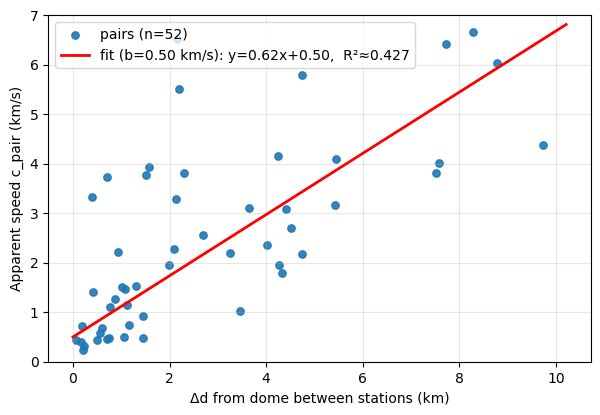

In [ ]:


from pathlib import Path
import numpy as np
import pandas as pd
from obspy import read, read_inventory
from importlib import reload
import flovopy.processing.envelopes as env
import flovopy.asl.envelope_locate as envloc
reload(env)
reload(envloc)
from flovopy.processing.envelopes import (
    align_waveforms,
    align_waveforms_global,
    envelopes_stream,
    envelope_delays,
    locate_with_grid_from_delays,
)
from flovopy.asl.envelope_locate import process_event, summarize_suite, parse_lags_column, \
    compute_pairwise_diffs, summarize_pairwise, estimate_speed_from_stable_pairs, plot_speed_vs_distance
from flovopy.asl.grid import Grid
from flovopy.asl.wrappers2 import find_event_files
from flovopy.core.mvo import dome_location

# -------------------------- Config --------------------------
PROJECTDIR      = "/Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver"
LOCALPROJECTDIR = "/Users/GlennThompson/work/PROJECTS/SSADenver_local"
OUTPUT_DIR      = f"{LOCALPROJECTDIR}/asl_results"
INPUT_DIR       = f"{PROJECTDIR}/ASL_inputs/biggest_pdc_events"
GLOBAL_CACHE    = f"{PROJECTDIR}/asl_global_cache"

INVENTORY_XML   = "/Users/glennthompson/Dropbox/MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT     = Path("/Users/glennthompson/Dropbox/MONTSERRAT_DEM_WGS84_MASTER.tif")
GRIDFILE_DEFAULT= "/Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl"

SMOOTH_SECONDS  = 1.0
MAX_LAG_SECONDS = 8.0
MIN_XCORR       = 0.5
best_file_nums  = [35, 36, 40, 52, 82, 83, 84, 116, 310, 338]

INV     = read_inventory(INVENTORY_XML)
gridobj = Grid.load(GRIDFILE_DEFAULT)
input_dir = Path(INPUT_DIR)
event_files = list(find_event_files(input_dir))
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("Dome (assumed source) =", dome_location)

# -------------------------- Run suite --------------------------
rows = []
per_event_lags = []  # store detailed lags to print later

for file_num in best_file_nums:
    try:
        event_path = str(event_files[file_num])
    except Exception as e:
        print(f"[WARN] file_num={file_num} not found in event_files list: {e}")
        continue

    eventdir       = Path(OUTPUT_DIR) / str(file_num)
    score_vs_c_png = str(eventdir / "score_vs_c.png")
    ccf_plot_dir   = str(eventdir / "ccf_plots")
    topo_png       = str(eventdir / "best_location_topo.png")
    eventdir.mkdir(parents=True, exist_ok=True)

    print(f"\n=== Event {file_num} ===")
    try:
        st = read(event_path).select(component="Z")
    except Exception as e:
        print(f"[ERROR] read failed for {event_path}: {e}")
        continue
    st.merge(fill_value="interpolate")
    st.detrend("linear")

    # Per-event
    res = process_event(st, gridobj, INV, GLOBAL_CACHE, dome_location, smooth_s=1.0, max_lag_s=8.0,
                min_corr=0.5, c_range=(0.1, 5.0), event_idx=file_num,
                output_dir=OUTPUT_DIR,           # <-- needed for score_vs_c.png
                topo_dem_path=DEM_DEFAULT,
           )       # optional, keeps topo plot
        # keep your Stage-A knobs here if you want to tweak:
        # min_delta_d_km=0.5, min_abs_lag_s=0.15, delta_d_weight=True, c_phys=(0.5,3.5)
    print(res)
    print(res["locator_result"]["speed"])
    rows.append(res["summary_row"])  

# ---------------- Suite summary -> stable pairwise -> speed & plot ----------------

# 1) Build the suite summary DataFrame and save it
df = summarize_suite(rows, f"{OUTPUT_DIR}/suite_summary.csv")
print("suite_summary columns:", list(df.columns))
print(df)

# 2) Parse per-event lags (prefer the global set; fall back if needed)
lags_col = (
    "lags_global" if "lags_global" in df.columns else
    ("lags_glb" if "lags_glb" in df.columns else None)
)
if lags_col is None:
    raise KeyError("No lags column found in suite summary (expected 'lags_global' or 'lags_glb').")

lags_glb = parse_lags_column(df[lags_col])          # -> list[dict{STA: lag_s}]
pairdiffs = compute_pairwise_diffs(lags_glb)        # -> list[dict{(STA,STA): dτ}]
stable_glb = summarize_pairwise(pairdiffs, "global")# -> DataFrame with sta_a/sta_b, mean_s, median_s, std, mad, ...

# Save the stable pairs (nice to keep for reproducibility)
stable_csv = Path(OUTPUT_DIR) / "pairwise_lagdiff_stats_global_stable.csv"
stable_glb.to_csv(stable_csv, index=False)
print(f"[stable] wrote -> {stable_csv}  (rows={len(stable_glb)})")

if stable_glb.empty:
    raise ValueError("Stable global pairwise table is empty — check your lags parsing and MAD filter.")

# 3) Estimate speed directly from the DataFrame (no need to re-read CSV)
res = estimate_speed_from_stable_pairs(
    grid=gridobj,
    inventory=INV,
    cache_dir=GLOBAL_CACHE,
    dome_location=dome_location,
    stable_df=stable_glb,         # <— pass the DataFrame
    use_value="mean_s",           # or "median_s"
    weight_with="mad_scaled",     # or "std" or None
    min_delta_d_km=0.0,           # relax if you want to keep all geometry
    min_abs_tau_s=0.0,
    c_bounds=(0.2, 7.0),
    uncert_floor_s=0.05,
)

print(f"Speed ≈ {res['speed_km_s']:.3f} km/s  (68% CI {res['ci_68'][0]:.3f}–{res['ci_68'][1]:.3f}) "
      f"using {res['n_pairs_used']} pairs")

per_pair = res["per_pair"]   # -> has delta_d_km, c_pair_km_s, weight

print(f"Speed (robust): {res['speed_km_s']:.3f} km/s "
      f"(68% CI {res['ci_68'][0]:.3f}-{res['ci_68'][1]:.3f}), "
      f"pairs used: {res['n_pairs_used']}")

# 4) Plot apparent speed vs Δd with a straight-line fit (intercept fixed at 0.5 km/s)
plot_speed_vs_distance(res, intercept=0.5, cmax=7.0)   # accepts dict OR res["per_pair"]

In [2]:
print(df)

   event_idx  c_at_bestnode_kms  score_bestnode  n_pairs_used  bestnode_lon  \
0         35           1.154430        0.519797             5    -62.158132   
1         36           0.844304        0.005882             5    -62.156723   
2         40           2.317969        0.059454             7    -62.225550   
3         52           2.115493        0.000032             3    -62.177568   
4         82           1.836709        0.350548             9    -62.193155   
5         83           1.016808        0.086693             6    -62.193531   
6         84           3.411392        0.345444             7    -62.206019   
7        116           0.844304        0.225871             7    -62.198414   
8        310           4.813924        0.000000             1    -62.202733   
9        338           0.100000        2.463003             6    -62.194752   

   bestnode_lat  bestnode_elev_m  \
0     16.747922              0.0   
1     16.728766              0.0   
2     16.731644       

# Run events from last cell, one event at a time, to check it works

In [ ]:
# --- Run ASL per event (cell 6) ---
summaries: List[Dict[str, Any]] = []

for i, ev in enumerate(selected_files, 1):
    print(f"[{i}/{len(event_files)}] {ev}")
    result = run_single_event(
        mseed_file=str(ev),
        cfg=cfg,
        refine_sector=False,
        station_gains_df=None,
        topo_kw=topo_kw,
        debug=True,
    )
    summaries.append(result)

# Summarize
df = pd.DataFrame(summaries)
display(df)

summary_csv = Path(OUTPUT_DIR) / f"{cfg.tag()}__summary.csv"
df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")

if not df.empty:
    n_ok = int((~df.get("error").notna()).sum()) if "error" in df.columns else len(df)
    print(f"Success: {n_ok}/{len(df)}")


# Run all events efficiently

In [ ]:
print(INPUT_DIR)
print(cfg)
print(topo_kw)
print(REFINE_SECTOR)
'''
run_all_events(
    input_dir=INPUT_DIR,
    station_gains_df = None,
    cfg=cfg,
    refine_sector=REFINE_SECTOR,
    topo_kw=topo_kw,
    debug=True,
    max_events=999999,
    use_multiprocessing=True,
    workers=4,
)
'''

# Run Monte Carlo sweep of parameters for 1 event


In [ ]:
icewebSpectrogram(st).plot(fmin=0.1, fmax=10.0, log=True, cmap='plasma', dbscale=False)

#outfile=None, secsPerFFT=None, fmin=0.5, fmax=20.0, log=False, cmap=pqlx, clim=None, equal_scale=False, title=None, add_colorbar=True, precompute=False, dbscale=False, trace_indexes=[] ): 

In [ ]:

from flovopy.asl.wrappers2 import run_event_monte_carlo
from flovopy.processing.sam import VSAM, DSAM
'''
# Simple 6-draw sweep (replace with your own priors/sequences)
configs = ASLConfig.generate_config_list(
    inventory=None,
    output_base=None,
    gridobj=None,
    global_cache=None,      
    wave_kinds=("surface","body"),
    station_corr_tables=(station_corrections_df), #annual_station_corrections_df),
    speeds=(1.0, 3.0),
    Qs=(23, 1000),
    dist_modes=("3d",), # 2d needs a different grid and different distance and amplitude corrections
    misfit_engines=("l2","r2", "lin"),
    peakfs=(2.0, 8.0),
    window_seconds = 5.0, # change to be a tuple 10.0) not implemented yet
    min_stations = 5,
    sam_class = (VSAM), #, DSAM), # not implemented yet
    sam_metric = ("mean"),# "median", "rms", "VT", "LP"), # this doesn't seem to be implemented yet
    # context can be set later; set here if you like:
    debug=False,
)

configs = ASLConfig.generate_config_list(
    inventory=None,
    output_base=None,
    gridobj=None,
    global_cache=None,      
    wave_kinds=("surface",),
    station_corr_tables=(station_corrections_df), #annual_station_corrections_df),
    speeds=(1.0, 3.0),
    Qs=(23, 1000),
    dist_modes=("3d",), # 2d needs a different grid and different distance and amplitude corrections
    misfit_engines=("l2"),
    peakfs=(8.0),
    window_seconds = 5.0, # change to be a tuple 10.0) not implemented yet
    min_stations = 5,
    sam_class = (VSAM), #, DSAM), # not implemented yet
    sam_metric = ("mean"),# "median", "rms", "VT", "LP"), # this doesn't seem to be implemented yet
    # context can be set later; set here if you like:
    debug=False,
)


configs = ASLConfig.generate_config_list(    
    inventory=INV,
    output_base=str(OUTPUT_DIR),
    gridobj=gridobj,
    global_cache=GLOBAL_CACHE,
) 

print(len(configs))
'''


In [ ]:

# Shared run context
mseed_file   = event_files[116]
'''
results = run_event_monte_carlo(
    mseed_file=mseed_file,
    configs=configs,
    inventory=INV,
    output_base=str(OUTPUT_DIR),
    gridobj=gridobj,
    topo_kw=topo_kw,
    station_gains_df=None,
    parallel=False,
    max_workers=1,
    global_cache=GLOBAL_CACHE,
    debug=True,
)

# Inspect or summarize results as needed
n_ok = sum(1 for r in results if "error" not in r)
print(f"[MC] Completed {n_ok}/{len(results)} runs OK")
'''